In [1]:
import pandas as pd
 
df_t= pd.read_csv('./Transactions.csv')
df_p= pd.read_csv('./Products.csv')
df_c= pd.read_csv('./Customers.csv')
 

In [2]:
# Convert date columns to datetime
df_t['TransactionDate'] = pd.to_datetime(df_t['TransactionDate'])
df_c['SignupDate'] = pd.to_datetime(df_c['SignupDate'])

# Validate CustomerID and ProductID relationships
invalid_customers = df_t[~df_t['CustomerID'].isin(df_c['CustomerID'])]  # Check for orphaned CustomerIDs
invalid_products = df_t[~df_t['ProductID'].isin(df_p['ProductID'])]     # Check for invalid ProductIDs

# Verify TotalValue = Quantity * Price
df_t['CalculatedValue'] = df_t['Quantity'] * df_t['Price']
discrepancies = df_t[df_t['TotalValue'] != df_t['CalculatedValue']]     # Flag mismatches

In [3]:
# Merge transactions with customer and product data
merged_data = df_t.merge(df_c, on='CustomerID', how='left')\
                  .merge(df_p, on='ProductID', how='left', suffixes=('_Txn', '_Product'))

In [13]:
merged_data.to_csv('merged_data.csv', index=False)

In [ ]:
%pip install scikit-learn


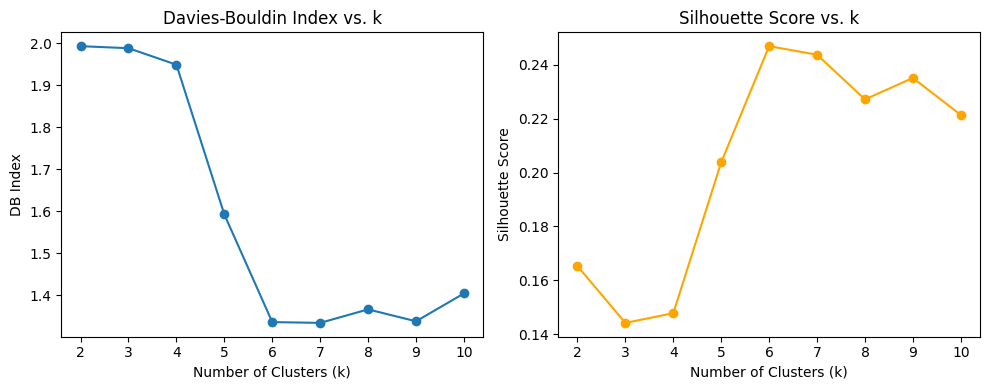

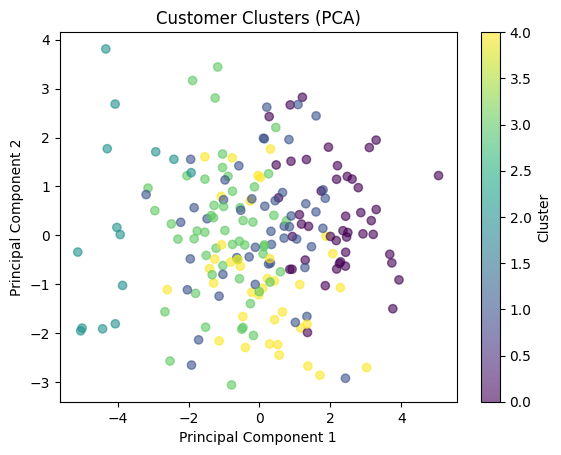

         TotalTransactions   TotalSpent  AvgTransactionValue     Recency  \
Cluster                                                                    
0                 7.500000  5700.437391           775.738647   86.369565   
1                 4.812500  3345.419583           683.309389   91.687500   
2                 1.500000   876.370714           542.828155  289.714286   
3                 3.849057  2513.725660           684.059818   85.320755   
4                 5.236842  3202.596053           644.496403  100.763158   

         UniqueProducts  UniqueCategories  AvgQuantity      Tenure  \
Cluster                                                              
0              7.152174          3.717391     2.754378  476.521739   
1              4.708333          2.791667     2.546396  487.416667   
2              1.500000          1.142857     2.398810  192.214286   
3              3.754717          2.452830     2.422956  532.226415   
4              5.236842          3.052632     2

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score
from sklearn.decomposition import PCA

# Load data
df_t = pd.read_csv('./Transactions.csv')
df_p = pd.read_csv('./Products.csv')
df_c = pd.read_csv('./Customers.csv')

# Convert date columns to datetime
df_t['TransactionDate'] = pd.to_datetime(df_t['TransactionDate'])
df_c['SignupDate'] = pd.to_datetime(df_c['SignupDate'])

# Merge data
merged_data = df_t.merge(df_c, on='CustomerID', how='left').merge(df_p, on='ProductID', how='left')

# ============================================
# Feature Engineering (Define `features` here)
# ============================================

# 1. Transaction Behavior Features (aggregate per customer)
transaction_features = merged_data.groupby('CustomerID').agg(
    TotalTransactions=('TransactionID', 'count'),
    TotalSpent=('TotalValue', 'sum'),
    AvgTransactionValue=('TotalValue', 'mean'),
    Recency=('TransactionDate', lambda x: (pd.to_datetime('today') - x.max()).days),
    UniqueProducts=('ProductID', 'nunique'),
    UniqueCategories=('Category', 'nunique'),
    AvgQuantity=('Quantity', 'mean')
).reset_index()

# 2. Customer Profile Features
# Calculate Tenure (days from signup to last transaction)
last_transaction_date = merged_data.groupby('CustomerID')['TransactionDate'].max().reset_index()
customer_features = df_c.merge(last_transaction_date, on='CustomerID', how='left')
customer_features['Tenure'] = (customer_features['TransactionDate'] - customer_features['SignupDate']).dt.days
customer_features = pd.get_dummies(customer_features[['CustomerID', 'Region', 'Tenure']], columns=['Region'])

# 3. Combine all features
features = transaction_features.merge(customer_features, on='CustomerID', how='left').drop(columns='CustomerID')

# Handle any missing values
features = features.fillna(features.mean())

# ============================================
# Clustering & Evaluation
# ============================================

# Scale features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Find optimal k using Davies-Bouldin Index
db_scores = []
silhouette_scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(scaled_features)
    db_scores.append(davies_bouldin_score(scaled_features, labels))
    silhouette_scores.append(silhouette_score(scaled_features, labels))

# Plot metrics
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(range(2, 11), db_scores, marker='o')
plt.title('Davies-Bouldin Index vs. k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('DB Index')

plt.subplot(1, 2, 2)
plt.plot(range(2, 11), silhouette_scores, marker='o', color='orange')
plt.title('Silhouette Score vs. k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.tight_layout()
plt.show()

# Choose optimal k (e.g., k=5 based on DB Index)
optimal_k = 5
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
labels = kmeans.fit_predict(scaled_features)

# Add cluster labels to features
features['Cluster'] = labels

# Visualize clusters using PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(scaled_features)
plt.scatter(principal_components[:, 0], principal_components[:, 1], c=labels, cmap='viridis', alpha=0.6)
plt.title('Customer Clusters (PCA)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster')
plt.show()

# Display cluster statistics
cluster_stats = features.groupby('Cluster').mean()
print(cluster_stats)
print(f"\nDavies-Bouldin Index for k={optimal_k}: {db_scores[optimal_k-2]:.3f}")
print(f"Silhouette Score for k={optimal_k}: {silhouette_scores[optimal_k-2]:.3f}")